## Class Activation Maps
Class Activation Maps (CAM) is a powerful technique used in Computer Vision for classification tasks. It allows the scientist to inspect the image to be categorized and understand which parts/pixels of that image have contributed more to the final output of the model.

The idea can be described as - 
- First a CNN sequential model (here) propagates forward and collects features from it
- Then, this is optimized by tallying with the original classfication and calculates the loss
- The loss is minimized by back propagation using the RMSProp with a learning rate (here)
- Then the weights and features activated are taken into account, and a dot product is taken to be called as class activations
- It necessarily means to show us the area of activations for that particular class

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.utils import plot_model

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cv2


import warnings
warnings.filterwarnings("ignore")

### Importing the Data
The images are catsvdogs from the tensorflow datasets, and is labelled 0 for cats and 1 for dogs

In [2]:
#removes progress bar
tfds.disable_progress_bar()

#80% train, 10% validation and test
train_data = tfds.load('cats_vs_dogs', split = 'train[:80%]', as_supervised = True)
validation_data = tfds.load('cats_vs_dogs', split = 'train[80%:90%]', as_supervised = True)
test_data = tfds.load('cats_vs_dogs', split = 'train[-10:]', as_supervised = True)

2022-01-01 15:57:59.337383: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


2022-01-01 15:58:33.464526: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-01 15:58:33.554476: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-01 15:58:33.555169: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-01 15:58:33.557133: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

### Preprocessing and Batching

We do minor augmentations here, just by casting it to float32, normalizing it, and resizing it to 300x300

In [3]:
#label is unaffected but train_data contains both image and a label
def augment_image(image, label):
    #cast to float
    image = tf.cast(image, tf.float32)
    #normalize the pixel values
    image = (image/255)
    #resize the image to 300x300
    image = tf.image.resize(image, (300,300))
    return image, label

#simpler method
def format_image(image, label):
    image = tf.image.resize(image, (300,300)) / 255.0
    return  image, label

In [4]:
augmented_train_data = train_data.map(augment_image)

#### Prefetch
Prefetching overlaps the preprocessing and model execution of a training step. While the model is executing training step s, the input pipeline is reading the data for step s+1. Doing so reduces the step time to the maximum (as opposed to the sum) of the training and the time it takes to extract the data.

The tf.data API provides the tf.data.Dataset.prefetch transformation. It can be used to decouple the time when data is produced from the time when data is consumed. In particular, the transformation uses a background thread and an internal buffer to prefetch elements from the input dataset ahead of the time they are requested. The number of elements to prefetch should be equal to (or possibly greater than) the number of batches consumed by a single training step. You could either manually tune this value, or set it to tf.data.AUTOTUNE, which will prompt the tf.data runtime to tune the value dynamically at runtime.

In [5]:
#keep 1024 items in the buffer and do batches of 32
train_batches = augmented_train_data.shuffle(1024).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
validation_batches = validation_data.map(format_image).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

### Classifier building
- Bunch of convolutional layers with pooling and a final sigmoid layer because this is a classification of 2 items

### A brief about GAP
Global average pooling (GAP) layers is used to minimize overfitting by reducing the total number of parameters in the model. Similar to max pooling layers, GAP layers are used to reduce the spatial dimensions of a three-dimensional tensor. However, GAP layers perform a more extreme type of dimensionality reduction, where a tensor with dimensions h×w×d is reduced in size to have dimensions 1×1×d. GAP layers reduce each h×w feature map to a single number by simply taking the average of all hw value

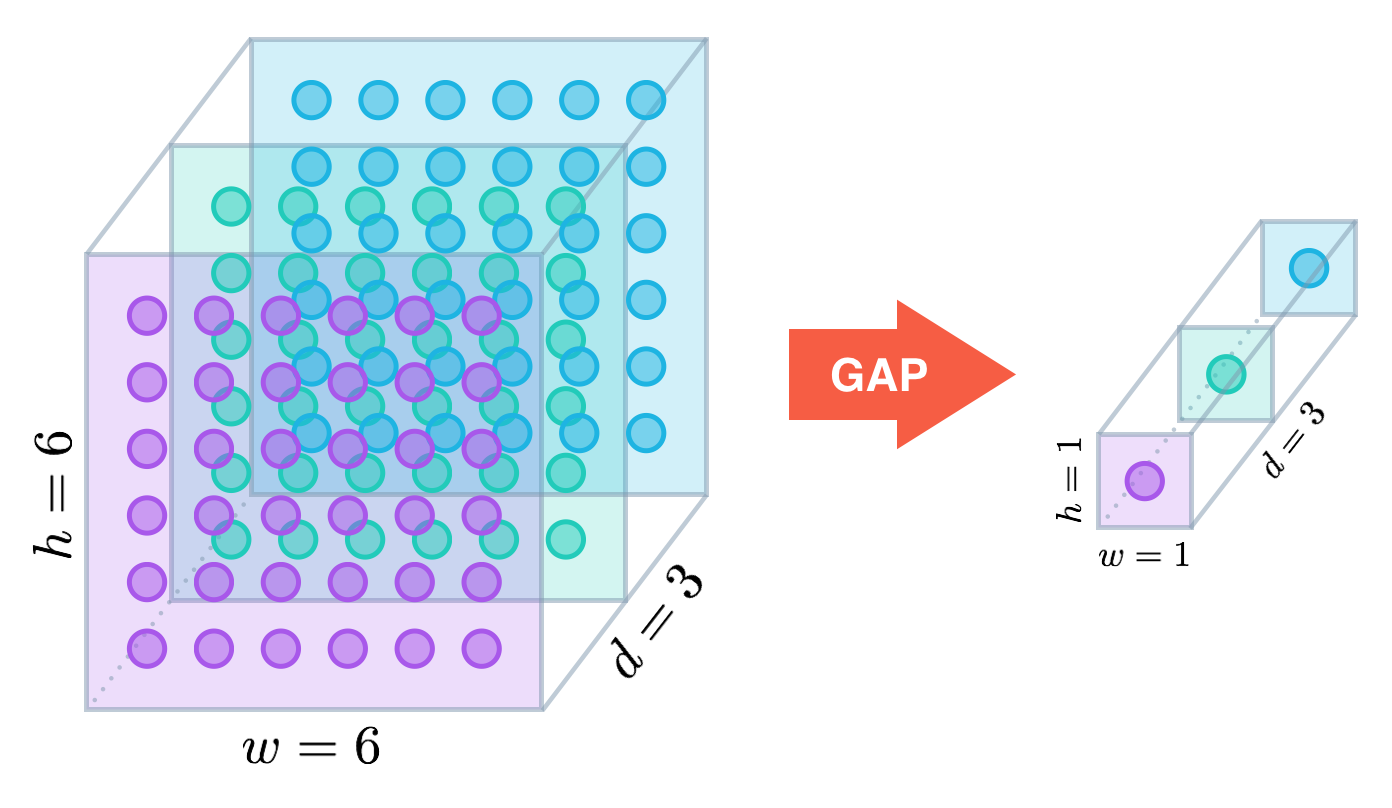

In mid-2016, researchers at MIT demonstrated that CNNs with GAP layers (a.k.a. GAP-CNNs) that have been trained for a classification task can also be used for object localization. That is, a GAP-CNN not only tells us what object is contained in the image - it also tells us where the object is in the image, and through no additional work on our part! The localization is expressed as a heat map (referred to as a class activation map), where the color-coding scheme identifies regions that are relatively important for the GAP-CNN to perform the object identification task

In [6]:
#model building
#same padding is zero padding outside, valid means no padding
#Global average pooling means 

model = Sequential()
model.add(Conv2D(16, input_shape = (300,300,3), kernel_size = (3,3), activation = 'relu', padding = 'same' ))
model.add(MaxPooling2D(pool_size = (2,2)))


model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same' ))
model.add(MaxPooling2D(pool_size = (2,2)))


model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same' ))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same' ))
model.add(GlobalAveragePooling2D())

model.add(Dense(1,activation='sigmoid'))

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 300, 300, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 128)       7

In [7]:
model.compile(loss = 'binary_crossentropy', metrics = ['accuracy'], optimizer = tf.keras.optimizers.RMSprop(lr = 0.001))
model.fit(train_batches, epochs = 25, validation_data=validation_batches)

Epoch 1/25


2022-01-01 15:58:36.892991: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-01 15:58:40.466458: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


167/582 [=======>......................] - ETA: 36s - loss: 0.6796 - accuracy: 0.5612

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/582 [=========>....................] - ETA: 34s - loss: 0.6774 - accuracy: 0.5683

209/582 [=========>....................] - ETA: 32s - loss: 0.6761 - accuracy: 0.5713

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/582 [=============>................] - ETA: 26s - loss: 0.6704 - accuracy: 0.5784

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


490/582 [========================>.....] - ETA: 7s - loss: 0.6622 - accuracy: 0.5911

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


503/582 [========================>.....] - ETA: 6s - loss: 0.6621 - accuracy: 0.5925

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


513/582 [=========================>....] - ETA: 5s - loss: 0.6613 - accuracy: 0.5937

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 3s - loss: 0.6593 - accuracy: 0.5959

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


546/582 [===========================>..] - ETA: 3s - loss: 0.6591 - accuracy: 0.5962

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6576 - accuracy: 0.5990

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 62s 91ms/step - loss: 0.6576 - accuracy: 0.5990 - val_loss: 0.6565 - val_accuracy: 0.6028
Epoch 2/25
167/582 [=======>......................] - ETA: 35s - loss: 0.6408 - accuracy: 0.6379

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/582 [=========>....................] - ETA: 32s - loss: 0.6367 - accuracy: 0.6420

209/582 [=========>....................] - ETA: 31s - loss: 0.6355 - accuracy: 0.6420

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/582 [=============>................] - ETA: 25s - loss: 0.6337 - accuracy: 0.6392

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


490/582 [========================>.....] - ETA: 7s - loss: 0.6240 - accuracy: 0.6487

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


502/582 [========================>.....] - ETA: 6s - loss: 0.6234 - accuracy: 0.6500

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


513/582 [=========================>....] - ETA: 5s - loss: 0.6221 - accuracy: 0.6505

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 3s - loss: 0.6201 - accuracy: 0.6517

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


546/582 [===========================>..] - ETA: 3s - loss: 0.6196 - accuracy: 0.6521

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6195 - accuracy: 0.6535

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 54s 89ms/step - loss: 0.6195 - accuracy: 0.6535 - val_loss: 0.6104 - val_accuracy: 0.6681
Epoch 3/25
168/582 [=======>......................] - ETA: 31s - loss: 0.6096 - accuracy: 0.6739

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


201/582 [=========>....................] - ETA: 29s - loss: 0.6124 - accuracy: 0.6724

211/582 [=========>....................] - ETA: 28s - loss: 0.6101 - accuracy: 0.6736

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


283/582 [=============>................] - ETA: 22s - loss: 0.6043 - accuracy: 0.6745

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


491/582 [========================>.....] - ETA: 6s - loss: 0.6023 - accuracy: 0.6791

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


504/582 [========================>.....] - ETA: 5s - loss: 0.6013 - accuracy: 0.6801

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


514/582 [=========================>....] - ETA: 5s - loss: 0.6009 - accuracy: 0.6808

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 3s - loss: 0.5991 - accuracy: 0.6819

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


548/582 [===========================>..] - ETA: 2s - loss: 0.5990 - accuracy: 0.6820

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/582 [============================>.] - ETA: 0s - loss: 0.5987 - accuracy: 0.6824

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 47s 78ms/step - loss: 0.5986 - accuracy: 0.6824 - val_loss: 0.5985 - val_accuracy: 0.6939
Epoch 4/25
167/582 [=======>......................] - ETA: 35s - loss: 0.5908 - accuracy: 0.6924

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/582 [=========>....................] - ETA: 32s - loss: 0.5907 - accuracy: 0.6911

208/582 [=========>....................] - ETA: 31s - loss: 0.5906 - accuracy: 0.6920

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 25s - loss: 0.5899 - accuracy: 0.6916

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


489/582 [========================>.....] - ETA: 7s - loss: 0.5869 - accuracy: 0.6938

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 6s - loss: 0.5869 - accuracy: 0.6939

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 5s - loss: 0.5864 - accuracy: 0.6945

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 3s - loss: 0.5858 - accuracy: 0.6956

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 3s - loss: 0.5849 - accuracy: 0.6962

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.5824 - accuracy: 0.6977

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 54s 88ms/step - loss: 0.5824 - accuracy: 0.6977 - val_loss: 0.7298 - val_accuracy: 0.6199
Epoch 5/25
168/582 [=======>......................] - ETA: 29s - loss: 0.5802 - accuracy: 0.7042

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


200/582 [=========>....................] - ETA: 27s - loss: 0.5814 - accuracy: 0.7036

210/582 [=========>....................] - ETA: 26s - loss: 0.5792 - accuracy: 0.7042

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


283/582 [=============>................] - ETA: 21s - loss: 0.5782 - accuracy: 0.7005

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


491/582 [========================>.....] - ETA: 6s - loss: 0.5732 - accuracy: 0.7054

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


504/582 [========================>.....] - ETA: 5s - loss: 0.5739 - accuracy: 0.7055

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


514/582 [=========================>....] - ETA: 5s - loss: 0.5735 - accuracy: 0.7054

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 3s - loss: 0.5721 - accuracy: 0.7062

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


548/582 [===========================>..] - ETA: 2s - loss: 0.5723 - accuracy: 0.7057

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/582 [============================>.] - ETA: 0s - loss: 0.5707 - accuracy: 0.7066

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 48s 78ms/step - loss: 0.5708 - accuracy: 0.7065 - val_loss: 0.5725 - val_accuracy: 0.7188
Epoch 6/25
167/582 [=======>......................] - ETA: 35s - loss: 0.5729 - accuracy: 0.7156

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/582 [=========>....................] - ETA: 33s - loss: 0.5690 - accuracy: 0.7151

209/582 [=========>....................] - ETA: 32s - loss: 0.5681 - accuracy: 0.7149

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/582 [=============>................] - ETA: 25s - loss: 0.5653 - accuracy: 0.7145

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


490/582 [========================>.....] - ETA: 7s - loss: 0.5655 - accuracy: 0.7160

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


503/582 [========================>.....] - ETA: 6s - loss: 0.5655 - accuracy: 0.7158

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


513/582 [=========================>....] - ETA: 5s - loss: 0.5658 - accuracy: 0.7156

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 3s - loss: 0.5634 - accuracy: 0.7169

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


546/582 [===========================>..] - ETA: 3s - loss: 0.5628 - accuracy: 0.7172

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.5609 - accuracy: 0.7181

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 55s 90ms/step - loss: 0.5609 - accuracy: 0.7181 - val_loss: 0.6364 - val_accuracy: 0.6556
Epoch 7/25
167/582 [=======>......................] - ETA: 35s - loss: 0.5577 - accuracy: 0.7223

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 33s - loss: 0.5587 - accuracy: 0.7233

209/582 [=========>....................] - ETA: 32s - loss: 0.5576 - accuracy: 0.7232

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 26s - loss: 0.5577 - accuracy: 0.7208

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 8s - loss: 0.5559 - accuracy: 0.7189

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


502/582 [========================>.....] - ETA: 6s - loss: 0.5545 - accuracy: 0.7201

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 6s - loss: 0.5554 - accuracy: 0.7192

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 3s - loss: 0.5529 - accuracy: 0.7200

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 3s - loss: 0.5526 - accuracy: 0.7208

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.5505 - accuracy: 0.7220

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 54s 90ms/step - loss: 0.5505 - accuracy: 0.7220 - val_loss: 0.5320 - val_accuracy: 0.7442
Epoch 8/25
168/582 [=======>......................] - ETA: 30s - loss: 0.5435 - accuracy: 0.7338

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


200/582 [=========>....................] - ETA: 28s - loss: 0.5404 - accuracy: 0.7325

211/582 [=========>....................] - ETA: 27s - loss: 0.5405 - accuracy: 0.7319

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


282/582 [=============>................] - ETA: 21s - loss: 0.5399 - accuracy: 0.7322

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


491/582 [========================>.....] - ETA: 6s - loss: 0.5408 - accuracy: 0.7335

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


504/582 [========================>.....] - ETA: 5s - loss: 0.5402 - accuracy: 0.7343

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 5s - loss: 0.5397 - accuracy: 0.7345

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 3s - loss: 0.5368 - accuracy: 0.7358

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


547/582 [===========================>..] - ETA: 2s - loss: 0.5366 - accuracy: 0.7359

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/582 [============================>.] - ETA: 0s - loss: 0.5363 - accuracy: 0.7357

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 49s 79ms/step - loss: 0.5364 - accuracy: 0.7357 - val_loss: 0.5414 - val_accuracy: 0.7360
Epoch 9/25
168/582 [=======>......................] - ETA: 29s - loss: 0.5296 - accuracy: 0.7426

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


200/582 [=========>....................] - ETA: 27s - loss: 0.5318 - accuracy: 0.7414

210/582 [=========>....................] - ETA: 27s - loss: 0.5338 - accuracy: 0.7399

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


283/582 [=============>................] - ETA: 22s - loss: 0.5299 - accuracy: 0.7426

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


491/582 [========================>.....] - ETA: 6s - loss: 0.5311 - accuracy: 0.7409

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


504/582 [========================>.....] - ETA: 5s - loss: 0.5309 - accuracy: 0.7414

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


514/582 [=========================>....] - ETA: 5s - loss: 0.5297 - accuracy: 0.7425

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 3s - loss: 0.5266 - accuracy: 0.7442

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


547/582 [===========================>..] - ETA: 2s - loss: 0.5260 - accuracy: 0.7440

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/582 [============================>.] - ETA: 0s - loss: 0.5255 - accuracy: 0.7443

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 47s 78ms/step - loss: 0.5257 - accuracy: 0.7440 - val_loss: 0.5191 - val_accuracy: 0.7610
Epoch 10/25
168/582 [=======>......................] - ETA: 31s - loss: 0.5259 - accuracy: 0.7459

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


200/582 [=========>....................] - ETA: 29s - loss: 0.5273 - accuracy: 0.7447

211/582 [=========>....................] - ETA: 28s - loss: 0.5248 - accuracy: 0.7463

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


283/582 [=============>................] - ETA: 22s - loss: 0.5252 - accuracy: 0.7478

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


491/582 [========================>.....] - ETA: 6s - loss: 0.5226 - accuracy: 0.7494

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


503/582 [========================>.....] - ETA: 6s - loss: 0.5217 - accuracy: 0.7497

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


514/582 [=========================>....] - ETA: 5s - loss: 0.5225 - accuracy: 0.7489

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 3s - loss: 0.5197 - accuracy: 0.7509

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


547/582 [===========================>..] - ETA: 2s - loss: 0.5195 - accuracy: 0.7510

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/582 [============================>.] - ETA: 0s - loss: 0.5170 - accuracy: 0.7519

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 50s 81ms/step - loss: 0.5176 - accuracy: 0.7519 - val_loss: 0.5084 - val_accuracy: 0.7657
Epoch 11/25
166/582 [=======>......................] - ETA: 35s - loss: 0.5154 - accuracy: 0.7577

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 32s - loss: 0.5151 - accuracy: 0.7573

208/582 [=========>....................] - ETA: 31s - loss: 0.5159 - accuracy: 0.7566

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 25s - loss: 0.5153 - accuracy: 0.7554

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 8s - loss: 0.5128 - accuracy: 0.7550

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


502/582 [========================>.....] - ETA: 6s - loss: 0.5135 - accuracy: 0.7545

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 6s - loss: 0.5125 - accuracy: 0.7552

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 3s - loss: 0.5108 - accuracy: 0.7556

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 3s - loss: 0.5105 - accuracy: 0.7561

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.5099 - accuracy: 0.7569

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 56s 92ms/step - loss: 0.5099 - accuracy: 0.7569 - val_loss: 0.4957 - val_accuracy: 0.7777
Epoch 12/25
166/582 [=======>......................] - ETA: 37s - loss: 0.5022 - accuracy: 0.7656

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 33s - loss: 0.5026 - accuracy: 0.7640

208/582 [=========>....................] - ETA: 32s - loss: 0.5039 - accuracy: 0.7632

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 26s - loss: 0.5029 - accuracy: 0.7640

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


489/582 [========================>.....] - ETA: 8s - loss: 0.5012 - accuracy: 0.7618

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


502/582 [========================>.....] - ETA: 7s - loss: 0.5013 - accuracy: 0.7615

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 6s - loss: 0.5014 - accuracy: 0.7614

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 3s - loss: 0.4992 - accuracy: 0.7625

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 3s - loss: 0.4986 - accuracy: 0.7627

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4974 - accuracy: 0.7637

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 57s 92ms/step - loss: 0.4974 - accuracy: 0.7637 - val_loss: 0.5368 - val_accuracy: 0.7274
Epoch 13/25
166/582 [=======>......................] - ETA: 35s - loss: 0.4991 - accuracy: 0.7675

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 33s - loss: 0.5010 - accuracy: 0.7647

208/582 [=========>....................] - ETA: 32s - loss: 0.5011 - accuracy: 0.7641

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 26s - loss: 0.4954 - accuracy: 0.7650

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


489/582 [========================>.....] - ETA: 8s - loss: 0.4937 - accuracy: 0.7668

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


502/582 [========================>.....] - ETA: 7s - loss: 0.4934 - accuracy: 0.7673

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 6s - loss: 0.4935 - accuracy: 0.7668

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 3s - loss: 0.4909 - accuracy: 0.7686

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 3s - loss: 0.4914 - accuracy: 0.7680

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4889 - accuracy: 0.7692

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 57s 93ms/step - loss: 0.4889 - accuracy: 0.7692 - val_loss: 0.7070 - val_accuracy: 0.6969
Epoch 14/25
166/582 [=======>......................] - ETA: 36s - loss: 0.4890 - accuracy: 0.7752

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 33s - loss: 0.4863 - accuracy: 0.7762

208/582 [=========>....................] - ETA: 32s - loss: 0.4848 - accuracy: 0.7766

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 25s - loss: 0.4812 - accuracy: 0.7762

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


489/582 [========================>.....] - ETA: 8s - loss: 0.4858 - accuracy: 0.7726

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 7s - loss: 0.4864 - accuracy: 0.7723

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 6s - loss: 0.4863 - accuracy: 0.7728

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 3s - loss: 0.4847 - accuracy: 0.7734

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 3s - loss: 0.4847 - accuracy: 0.7731

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4829 - accuracy: 0.7746

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 57s 93ms/step - loss: 0.4829 - accuracy: 0.7746 - val_loss: 0.4767 - val_accuracy: 0.7807
Epoch 15/25
165/582 [=======>......................] - ETA: 38s - loss: 0.4766 - accuracy: 0.7828

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 36s - loss: 0.4829 - accuracy: 0.7792

208/582 [=========>....................] - ETA: 35s - loss: 0.4833 - accuracy: 0.7779

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 27s - loss: 0.4806 - accuracy: 0.7797

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


489/582 [========================>.....] - ETA: 8s - loss: 0.4805 - accuracy: 0.7804

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 7s - loss: 0.4805 - accuracy: 0.7803

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 6s - loss: 0.4806 - accuracy: 0.7802

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 3s - loss: 0.4779 - accuracy: 0.7817

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 3s - loss: 0.4775 - accuracy: 0.7819

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/582 [============================>.] - ETA: 0s - loss: 0.4759 - accuracy: 0.7828

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 58s 96ms/step - loss: 0.4762 - accuracy: 0.7826 - val_loss: 0.4653 - val_accuracy: 0.7958
Epoch 16/25
167/582 [=======>......................] - ETA: 36s - loss: 0.4705 - accuracy: 0.7850

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/582 [=========>....................] - ETA: 33s - loss: 0.4698 - accuracy: 0.7833

209/582 [=========>....................] - ETA: 32s - loss: 0.4706 - accuracy: 0.7820

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/582 [=============>................] - ETA: 25s - loss: 0.4677 - accuracy: 0.7816

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


489/582 [========================>.....] - ETA: 8s - loss: 0.4713 - accuracy: 0.7821

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


502/582 [========================>.....] - ETA: 7s - loss: 0.4721 - accuracy: 0.7818

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


513/582 [=========================>....] - ETA: 6s - loss: 0.4719 - accuracy: 0.7818

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 3s - loss: 0.4706 - accuracy: 0.7830

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


546/582 [===========================>..] - ETA: 3s - loss: 0.4706 - accuracy: 0.7831

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4686 - accuracy: 0.7836

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 56s 93ms/step - loss: 0.4686 - accuracy: 0.7836 - val_loss: 0.5152 - val_accuracy: 0.7674
Epoch 17/25
164/582 [=======>......................] - ETA: 34s - loss: 0.4697 - accuracy: 0.7873

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


196/582 [=========>....................] - ETA: 32s - loss: 0.4663 - accuracy: 0.7867

206/582 [=========>....................] - ETA: 31s - loss: 0.4642 - accuracy: 0.7881

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


278/582 [=============>................] - ETA: 25s - loss: 0.4642 - accuracy: 0.7880

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 8s - loss: 0.4614 - accuracy: 0.7891

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


499/582 [========================>.....] - ETA: 7s - loss: 0.4611 - accuracy: 0.7896

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 6s - loss: 0.4616 - accuracy: 0.7888

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 3s - loss: 0.4585 - accuracy: 0.7906

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


548/582 [===========================>..] - ETA: 2s - loss: 0.4585 - accuracy: 0.7908

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4573 - accuracy: 0.7917

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 55s 90ms/step - loss: 0.4573 - accuracy: 0.7917 - val_loss: 0.4513 - val_accuracy: 0.8014
Epoch 18/25
168/582 [=======>......................] - ETA: 31s - loss: 0.4595 - accuracy: 0.7894

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


200/582 [=========>....................] - ETA: 28s - loss: 0.4568 - accuracy: 0.7903

209/582 [=========>....................] - ETA: 28s - loss: 0.4554 - accuracy: 0.7899

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


283/582 [=============>................] - ETA: 24s - loss: 0.4535 - accuracy: 0.7925

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


491/582 [========================>.....] - ETA: 7s - loss: 0.4526 - accuracy: 0.7947

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


504/582 [========================>.....] - ETA: 6s - loss: 0.4530 - accuracy: 0.7943

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


514/582 [=========================>....] - ETA: 5s - loss: 0.4518 - accuracy: 0.7951

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 3s - loss: 0.4497 - accuracy: 0.7957

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


547/582 [===========================>..] - ETA: 2s - loss: 0.4499 - accuracy: 0.7962

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/582 [============================>.] - ETA: 0s - loss: 0.4470 - accuracy: 0.7974

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 50s 83ms/step - loss: 0.4470 - accuracy: 0.7974 - val_loss: 0.5878 - val_accuracy: 0.7429
Epoch 19/25
168/582 [=======>......................] - ETA: 35s - loss: 0.4531 - accuracy: 0.7919

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


200/582 [=========>....................] - ETA: 31s - loss: 0.4490 - accuracy: 0.7936

210/582 [=========>....................] - ETA: 31s - loss: 0.4496 - accuracy: 0.7933

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


283/582 [=============>................] - ETA: 24s - loss: 0.4454 - accuracy: 0.7936

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


491/582 [========================>.....] - ETA: 7s - loss: 0.4456 - accuracy: 0.7928

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


504/582 [========================>.....] - ETA: 6s - loss: 0.4450 - accuracy: 0.7931

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


514/582 [=========================>....] - ETA: 5s - loss: 0.4444 - accuracy: 0.7932

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 3s - loss: 0.4435 - accuracy: 0.7942

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


547/582 [===========================>..] - ETA: 2s - loss: 0.4426 - accuracy: 0.7948

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4417 - accuracy: 0.7957

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 50s 81ms/step - loss: 0.4417 - accuracy: 0.7957 - val_loss: 0.5195 - val_accuracy: 0.7597
Epoch 20/25
168/582 [=======>......................] - ETA: 29s - loss: 0.4397 - accuracy: 0.8017

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


200/582 [=========>....................] - ETA: 27s - loss: 0.4390 - accuracy: 0.8020

211/582 [=========>....................] - ETA: 26s - loss: 0.4422 - accuracy: 0.8008

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


282/582 [=============>................] - ETA: 23s - loss: 0.4358 - accuracy: 0.8018

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


491/582 [========================>.....] - ETA: 7s - loss: 0.4341 - accuracy: 0.8035

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


504/582 [========================>.....] - ETA: 6s - loss: 0.4345 - accuracy: 0.8039

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


514/582 [=========================>....] - ETA: 5s - loss: 0.4339 - accuracy: 0.8041

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 3s - loss: 0.4322 - accuracy: 0.8052

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


548/582 [===========================>..] - ETA: 2s - loss: 0.4316 - accuracy: 0.8053

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/582 [============================>.] - ETA: 0s - loss: 0.4306 - accuracy: 0.8062

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 50s 81ms/step - loss: 0.4308 - accuracy: 0.8061 - val_loss: 0.4846 - val_accuracy: 0.7739
Epoch 21/25
168/582 [=======>......................] - ETA: 30s - loss: 0.4361 - accuracy: 0.8062

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


200/582 [=========>....................] - ETA: 28s - loss: 0.4286 - accuracy: 0.8109

211/582 [=========>....................] - ETA: 27s - loss: 0.4300 - accuracy: 0.8097

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


282/582 [=============>................] - ETA: 22s - loss: 0.4273 - accuracy: 0.8096

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


490/582 [========================>.....] - ETA: 6s - loss: 0.4263 - accuracy: 0.8121

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


503/582 [========================>.....] - ETA: 5s - loss: 0.4251 - accuracy: 0.8129

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


513/582 [=========================>....] - ETA: 5s - loss: 0.4234 - accuracy: 0.8137

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 3s - loss: 0.4230 - accuracy: 0.8142

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


546/582 [===========================>..] - ETA: 2s - loss: 0.4233 - accuracy: 0.8135

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4235 - accuracy: 0.8130

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 50s 82ms/step - loss: 0.4235 - accuracy: 0.8130 - val_loss: 0.4154 - val_accuracy: 0.8229
Epoch 22/25
168/582 [=======>......................] - ETA: 30s - loss: 0.4299 - accuracy: 0.8181

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


201/582 [=========>....................] - ETA: 27s - loss: 0.4260 - accuracy: 0.8176

210/582 [=========>....................] - ETA: 27s - loss: 0.4228 - accuracy: 0.8190

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


283/582 [=============>................] - ETA: 21s - loss: 0.4199 - accuracy: 0.8182

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


491/582 [========================>.....] - ETA: 6s - loss: 0.4234 - accuracy: 0.8140

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


504/582 [========================>.....] - ETA: 5s - loss: 0.4231 - accuracy: 0.8142

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


514/582 [=========================>....] - ETA: 4s - loss: 0.4230 - accuracy: 0.8134

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 2s - loss: 0.4212 - accuracy: 0.8142

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


548/582 [===========================>..] - ETA: 2s - loss: 0.4215 - accuracy: 0.8144

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/582 [============================>.] - ETA: 0s - loss: 0.4202 - accuracy: 0.8156

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 47s 77ms/step - loss: 0.4198 - accuracy: 0.8159 - val_loss: 0.4543 - val_accuracy: 0.8078
Epoch 23/25
168/582 [=======>......................] - ETA: 39s - loss: 0.4214 - accuracy: 0.8153

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


200/582 [=========>....................] - ETA: 34s - loss: 0.4230 - accuracy: 0.8130

211/582 [=========>....................] - ETA: 33s - loss: 0.4186 - accuracy: 0.8146

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


283/582 [=============>................] - ETA: 25s - loss: 0.4150 - accuracy: 0.8154

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


491/582 [========================>.....] - ETA: 7s - loss: 0.4138 - accuracy: 0.8159

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


504/582 [========================>.....] - ETA: 6s - loss: 0.4132 - accuracy: 0.8162

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


514/582 [=========================>....] - ETA: 5s - loss: 0.4128 - accuracy: 0.8164

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 3s - loss: 0.4127 - accuracy: 0.8163

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


548/582 [===========================>..] - ETA: 2s - loss: 0.4118 - accuracy: 0.8168

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/582 [============================>.] - ETA: 0s - loss: 0.4113 - accuracy: 0.8177

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 51s 84ms/step - loss: 0.4115 - accuracy: 0.8176 - val_loss: 0.4391 - val_accuracy: 0.8005
Epoch 24/25
168/582 [=======>......................] - ETA: 34s - loss: 0.4164 - accuracy: 0.8237

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


200/582 [=========>....................] - ETA: 31s - loss: 0.4171 - accuracy: 0.8198

210/582 [=========>....................] - ETA: 30s - loss: 0.4141 - accuracy: 0.8207

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


283/582 [=============>................] - ETA: 23s - loss: 0.4101 - accuracy: 0.8209

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


491/582 [========================>.....] - ETA: 6s - loss: 0.4094 - accuracy: 0.8234

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


504/582 [========================>.....] - ETA: 5s - loss: 0.4091 - accuracy: 0.8237

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


513/582 [=========================>....] - ETA: 5s - loss: 0.4089 - accuracy: 0.8238

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 3s - loss: 0.4085 - accuracy: 0.8234

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


548/582 [===========================>..] - ETA: 2s - loss: 0.4078 - accuracy: 0.8237

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4064 - accuracy: 0.8243

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 50s 81ms/step - loss: 0.4064 - accuracy: 0.8243 - val_loss: 0.8452 - val_accuracy: 0.6986
Epoch 25/25
166/582 [=======>......................] - ETA: 41s - loss: 0.4169 - accuracy: 0.8187

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 37s - loss: 0.4116 - accuracy: 0.8201

208/582 [=========>....................] - ETA: 35s - loss: 0.4101 - accuracy: 0.8200

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 28s - loss: 0.4062 - accuracy: 0.8200

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


489/582 [========================>.....] - ETA: 8s - loss: 0.4070 - accuracy: 0.8198

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 7s - loss: 0.4066 - accuracy: 0.8200

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 6s - loss: 0.4056 - accuracy: 0.8208

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 3s - loss: 0.4033 - accuracy: 0.8225

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 3s - loss: 0.4028 - accuracy: 0.8228

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4012 - accuracy: 0.8241

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 57s 93ms/step - loss: 0.4012 - accuracy: 0.8241 - val_loss: 0.4608 - val_accuracy: 0.8005


In [8]:
model.layers[-1].weights

[<tf.Variable 'dense/kernel:0' shape=(128, 1) dtype=float32, numpy=
 array([[ 0.1890183 ],
        [ 0.22102585],
        [-0.10522248],
        [ 0.18669719],
        [ 0.15091784],
        [ 0.32749212],
        [ 0.17565084],
        [-0.34676173],
        [-0.36240113],
        [-0.18444395],
        [-0.12346527],
        [ 0.15061477],
        [ 0.16819602],
        [ 0.17079434],
        [-0.2850429 ],
        [ 0.17060979],
        [ 0.15232073],
        [ 0.17682059],
        [ 0.16980256],
        [-0.1587873 ],
        [-0.25739044],
        [-0.27015615],
        [-0.31390706],
        [-0.19804046],
        [-0.30318323],
        [ 0.3887316 ],
        [-0.19113453],
        [ 0.16570656],
        [-0.20427385],
        [-0.3198699 ],
        [ 0.16181648],
        [ 0.205718  ],
        [-0.1884618 ],
        [-0.22566742],
        [ 0.19338399],
        [ 0.13101867],
        [ 0.15477224],
        [-0.19635025],
        [ 0.15678217],
        [-0.17229211],
        [-0.

### Building the CAM model

The idea is the following: imagine we have a trained CNN and we feed it with a new image. It will return a class for that image. Then, if we take the output feature map of the last convolutional layer and weight every channel by the gradient of the output class (w.r.t. to the channel), we obtain a heatmap indicating which are the parts of the input image which activate the class the most.

In [9]:
gap_model = model.layers[-1].get_weights()[0]

gap_model.shape

(128, 1)

In [10]:
gap_weights = model.layers[-1].get_weights()[0]
gap_weights.shape

cam_model  = Model(inputs=model.input,outputs=(model.layers[-3].output,model.layers[-1].output))
cam_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 300, 300, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 300, 300, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 64)        0     

### Brief Description on Spline interpolation
In the mathematical field of numerical analysis, spline interpolation is a form of interpolation where the interpolant is a special type of piecewise polynomial called a spline. That is, instead of fitting a single, high-degree polynomial to all of the values at once, spline interpolation fits low-degree polynomials to small subsets of the values, for example, fitting nine cubic polynomials between each of the pairs of ten points, instead of fitting a single degree-ten polynomial to all of them. Spline interpolation is often preferred over polynomial interpolation because the interpolation error can be made small even when using low-degree polynomials for the spline. Here a 300/37 ratio is taken in order to interpolate a 37x37 image before GAP to the original size of the image.


In [11]:
def show_cam(image_value, features, results):
  '''
  Displays the class activation map of an image

  Args:
    image_value (tensor) -- preprocessed input image with size 300 x 300
    features (array) -- features of the image, shape (1, 37, 37, 128)
    results (array) -- output of the sigmoid layer
  '''

  # there is only one image in the batch so we index at `0`
  features_for_img = features[0]
  prediction = results[0]

  # there is only one unit in the output so we get the weights connected to it
  class_activation_weights = gap_weights[:,0]

  # upsample to the image size
  class_activation_features = sp.ndimage.zoom(features_for_img, (300/37, 300/37, 1), order=2)
  #spline interpolation of order = 2 (G search)
  
  # compute the intensity of each feature in the CAM
  cam_output  = np.dot(class_activation_features,class_activation_weights)

  # visualize the results
  print(f'sigmoid output: {results}')
  print(f"prediction: {'dog' if round(results[0][0]) else 'cat'}")
  plt.figure(figsize=(8,8))
  plt.imshow(cam_output, cmap='jet', alpha=0.5)
  plt.imshow(tf.squeeze(image_value), alpha=0.5)
  plt.show()


#Given a tensor input, this operation returns a tensor of the same type with all dimensions of size 1 removed. - tf.squeeze

In [12]:
!wget -O cat1.jpg https://upload.wikimedia.org/wikipedia/commons/thumb/a/a3/June_odd-eyed-cat.jpg/1106px-June_odd-eyed-cat.jpg

--2022-01-01 16:28:16--  https://upload.wikimedia.org/wikipedia/commons/thumb/a/a3/June_odd-eyed-cat.jpg/1106px-June_odd-eyed-cat.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 153908 (150K) [image/jpeg]
Saving to: ‘cat1.jpg’

cat1.jpg            100%[===================>] 150.30K   790KB/s    in 0.2s    

2022-01-01 16:28:17 (790 KB/s) - ‘cat1.jpg’ saved [153908/153908]



sigmoid output: [[0.07032078]]
prediction: cat


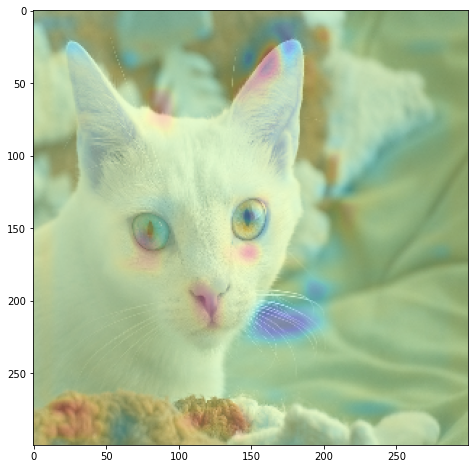

In [13]:
# utility function to preprocess an image and show the CAM
def convert_and_classify(image):

  # load the image
  img = cv2.imread(image)

  # preprocess the image before feeding it to the model
  img = cv2.resize(img, (300,300)) / 255.0

  # add a batch dimension because the model expects it
  tensor_image = np.expand_dims(img, axis=0)

  # get the features and prediction
  features,results = cam_model.predict(tensor_image)
  
  # generate the CAM
  show_cam(tensor_image, features, results)

convert_and_classify('cat1.jpg')

ground truth: dog
sigmoid output: [[0.22083446]]
prediction: cat


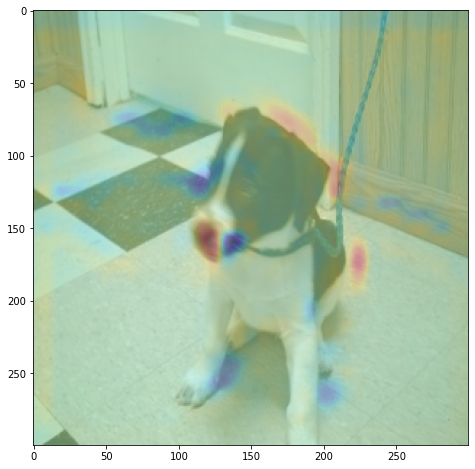

ground truth: dog
sigmoid output: [[0.804437]]
prediction: dog


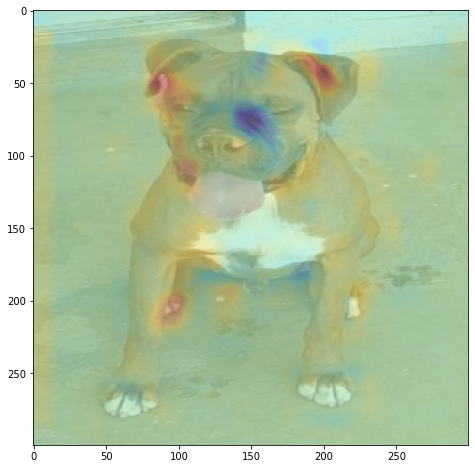

ground truth: cat
sigmoid output: [[0.00716922]]
prediction: cat


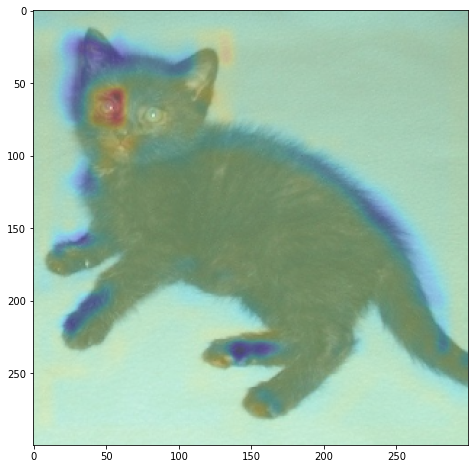

ground truth: dog
sigmoid output: [[0.8266013]]
prediction: dog


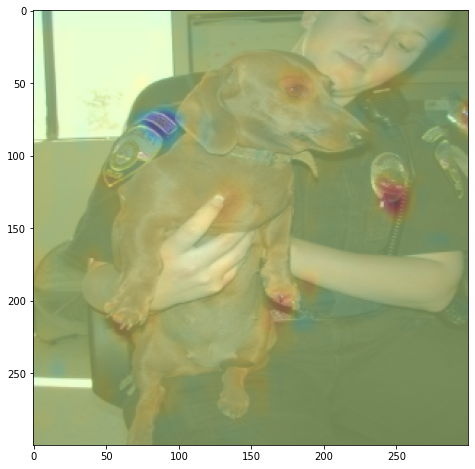

ground truth: cat
sigmoid output: [[0.00049801]]
prediction: cat


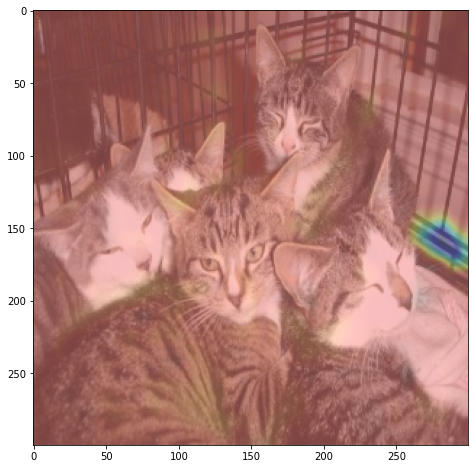

In [14]:
# preprocess the test images
augmented_test_data = test_data.map(augment_image)
test_batches = augmented_test_data.batch(1)


for img, lbl in test_batches.take(5):
  print(f"ground truth: {'dog' if lbl else 'cat'}")
  features,results = cam_model.predict(img)
  show_cam(img, features, results)

If your training reached 80% accuracy, you may notice from the images above that the presence of eyes and nose play a big part in determining a dog, while whiskers and a colar mostly point to a cat. Some can be misclassified based on the presence or absence of these features. This tells us that the model is not yet performing optimally and we need to tweak our process (e.g. add more data, train longer, use a different model, etc).